<a href="https://colab.research.google.com/github/imtiaz114/Brain_tumor_detection_from_2D_MRI_images/blob/main/Brain_tumor_detection_DL_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Baseline

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import tensorflow_datasets as tfds

import shutil, random, os,glob
import cv2
import tempfile

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = (224,224)
INITIAL_EPOCHS = 100

## Prepare the dataset

etar age augmentation kore data barabo then okhan theke erom array te nibo, taile dataset soman kroa jabe I guess

In [ ]:
#counting files
os.chdir('/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/non_tumor/')
count = 0
for f in glob.glob("*"):
  count += 1

print(count)

20


In [ ]:
x_train = np.zeros(((202,IMG_SIZE[0],IMG_SIZE[1],3)))
x_test  = np.zeros(((51,IMG_SIZE[0],IMG_SIZE[1],3)))
y_train = np.zeros(202,dtype = np.uint8)
y_test  = np.zeros(51,dtype = np.uint8)

In [ ]:
#train yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_train[count,:,:,:]  = img
  y_train[count] = 1
  #print(count)
  count += 1

In [ ]:
#train no
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/non_tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_train[count,:,:,:]  = img
  y_train[count] = 0
  #print(count)
  count += 1

In [ ]:
#test yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_test[count,:,:,:]  = img
  y_test[count] = 1
  print(count)
  count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
#test no
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/non_tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_test[count,:,:,:]  = img
  y_test[count] = 0
  print(count)
  count += 1

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [ ]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(202, 224, 224, 3) (202,) (51, 224, 224, 3) (51,)


### verifying

In [ ]:
print(np.sum(y_train == 0),np.sum(y_test == 0))
print(np.sum(y_train == 1),np.sum(y_test == 1))

78 20
124 31


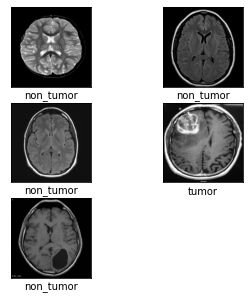

In [ ]:
class_names = ['non_tumor','tumor']

plt.figure(figsize=(5,5))

idx = np.random.randint(0,175,5)
i = 0
for i in range(len(idx)):
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[int(idx[i])])
    #print(y_train[idx[i]])
    plt.xlabel(class_names[y_train[idx[i]]])
    i += 1
plt.show()

## Defining the model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))

  LR = 0.001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR, beta_1=0.9,beta_2=0.999, epsilon=None,amsgrad=False),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

## Training the model

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               50466944  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 50,467,969
Trainable params: 50,467,969
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=25,
    mode='max',
    restore_best_weights=True)

In [ ]:
history = model.fit(x_train,y_train, epochs=INITIAL_EPOCHS,steps_per_epoch=10, batch_size= BATCH_SIZE,callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


10/10 [==============================] - 44s 22ms/step - loss: 8.2831 - accuracy: 0.5544
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 3.0125 - accuracy: 0.6635
Epoch 3/100
10/10 [==============================] - 0s 26ms/step - loss: 2.0454 - accuracy: 0.7044
Epoch 4/100
10/10 [==============================] - 0s 20ms/step - loss: 2.2219 - accuracy: 0.6816
Epoch 5/100
10/10 [==============================] - 0s 20ms/step - loss: 0.5640 - accuracy: 0.7467
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 0.1307 - accuracy: 0.9722
Epoch 7/100
10/10 [==============================] - 0s 21ms/step - loss: 0.2572 - accuracy: 0.8900
Epoch 8/100
10/10 [==============================] - 0s 20ms/step - loss: 0.1814 - accuracy: 0.9276
Epoch 9/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0520 - accuracy: 0.9769
Epoch 10/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0469 - accuracy: 1.0000
Epoch 11/1

## Evaluate the model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


2/2 - 1s - loss: 0.2665 - accuracy: 0.9216
0.26653438806533813 0.9215686321258545


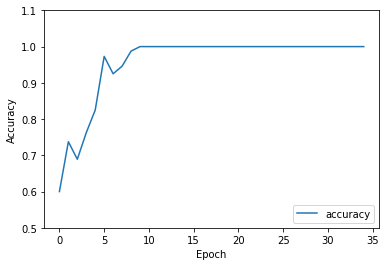

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,y_test, verbose=2)
print(test_loss, test_acc)

# mainly the training dataset is overfitting, I think fixing it will help

here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.

# 2. Baseline with augmentation + data imbalance handling

it's performing worst than baseline

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import tensorflow_datasets as tfds

import shutil, random, os,glob
import cv2
import tempfile

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (224,224)
INITIAL_EPOCHS = 100

## Preparing Dataset

In [ ]:
#using 224x224
x_train = np.zeros(((202,IMG_SIZE[0],IMG_SIZE[1],3)))
x_test  = np.zeros(((51,IMG_SIZE[0],IMG_SIZE[1],3)))
y_train = np.zeros(202,dtype = np.uint8)
y_test  = np.zeros(51,dtype = np.uint8)

In [ ]:
#train yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_train[count,:,:,:]  = img
  y_train[count] = 1
  #print(count)
  count += 1

In [ ]:
#train no
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/non_tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_train[count,:,:,:]  = img
  y_train[count] = 0
  #print(count)
  count += 1

In [ ]:
#test yes
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_test[count,:,:,:]  = img
  y_test[count] = 1
  #print(count)
  count += 1

In [ ]:
#test no
dirpath = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/non_tumor/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  img = cv2.imread(fname)
  x_test[count,:,:,:]  = img
  y_test[count] = 0
  #print(count)
  count += 1

In [ ]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(202, 224, 224, 3) (202,) (51, 224, 224, 3) (51,)


### verifying

In [ ]:
print(np.sum(y_train == 0),np.sum(y_test == 0))
print(np.sum(y_train == 1),np.sum(y_test == 1))

78 20
124 31


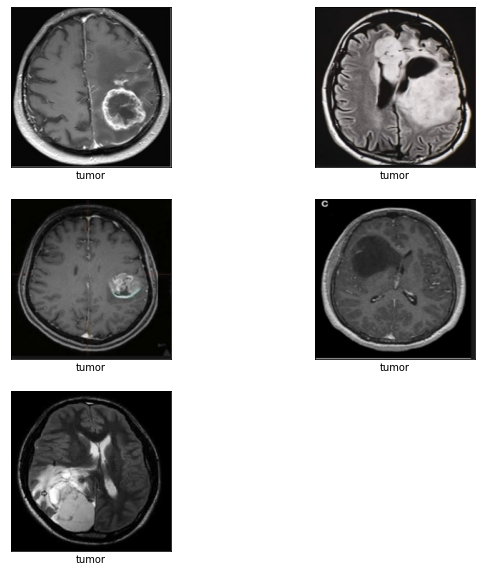

In [ ]:
class_names = ['non_tumor','tumor']

plt.figure(figsize=(10,10))

idx = np.random.randint(0,175,5)
i = 0
for i in range(len(idx)):
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[int(idx[i])])
    #print(y_train[idx[i]])
    plt.xlabel(class_names[y_train[idx[i]]])
    i += 1
plt.show()

## Defining the model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
def make_model(metrics=METRICS,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))

  LR = 0.001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR, beta_1=0.9,beta_2=0.999, epsilon=None,amsgrad=False),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

## Building the model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=25,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               50466944  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 50,467,969
Trainable params: 50,467,969
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#test running the model
model.predict(x_train[:10])

array([[0.283874  ],
       [0.28640884],
       [0.30567893],
       [0.2891989 ],
       [0.3075562 ],
       [0.30381495],
       [0.28627947],
       [0.275909  ],
       [0.25599733],
       [0.29367465]], dtype=float32)

## Setting the correct initial bias

In [ ]:
results = model.evaluate(x_train,y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]),"Acc: {:0.4f}".format(results[1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


Loss: 0.8843 Acc: 0.3861


In [ ]:
pos = 155
neg = 98
initial_bias = np.log([pos/neg])
initial_bias

array([0.45845764])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(x_train[:10])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


array([[0.6384113 ],
       [0.6168499 ],
       [0.6227755 ],
       [0.67562675],
       [0.64691705],
       [0.6034999 ],
       [0.63811463],
       [0.63037354],
       [0.6799626 ],
       [0.6359399 ]], dtype=float32)

In [ ]:
results = model.evaluate(x_train,y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]),"Acc: {:0.4f}".format(results[1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


Loss: 0.6745 Acc: 0.6139


### Checkpoint the initial weights


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that this bias fix helps

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20, 
    verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20, 
    verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.legend(loc="lower left")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

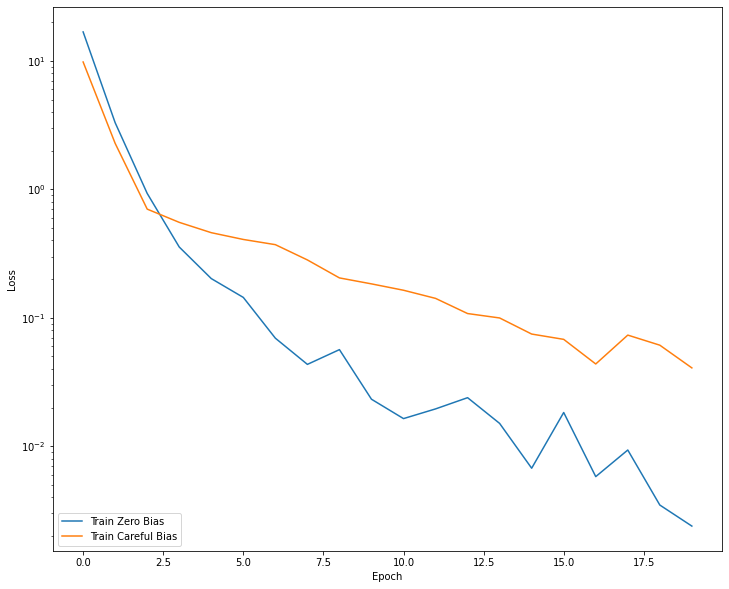

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
def plot_acc(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['accuracy'],
               color=colors[n], label='Train ' + label)
  plt.legend(loc="lower left")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

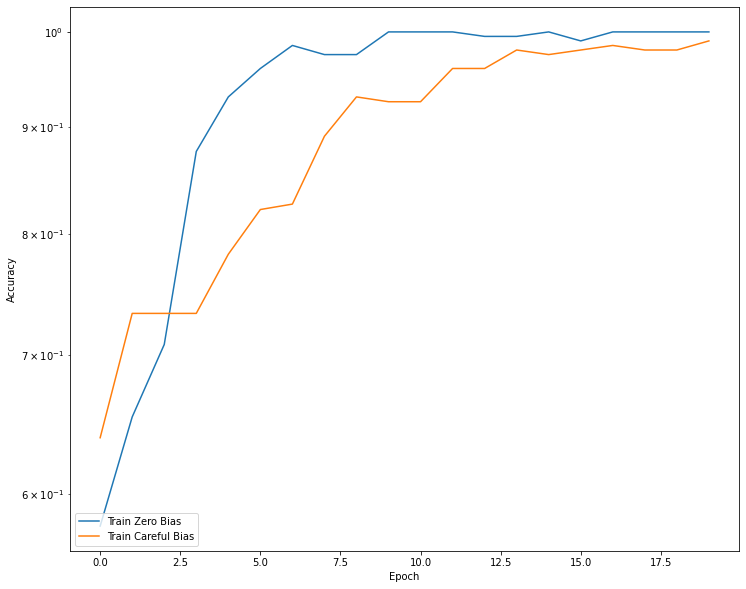

In [ ]:
plot_acc(zero_bias_history, "Zero Bias", 0)
plot_acc(careful_bias_history, "Careful Bias", 1)

## Training the new model

In [ ]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    x=aug.flow(x_train,y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=10,
    batch_size=BATCH_SIZE,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


10/10 [==============================] - 3s 170ms/step - loss: 9.0302 - accuracy: 0.5864
Epoch 2/100
10/10 [==============================] - 1s 163ms/step - loss: 5.9931 - accuracy: 0.4836
Epoch 3/100
10/10 [==============================] - 2s 162ms/step - loss: 1.3271 - accuracy: 0.6038
Epoch 4/100
10/10 [==============================] - 2s 160ms/step - loss: 0.8514 - accuracy: 0.5480
Epoch 5/100
10/10 [==============================] - 2s 167ms/step - loss: 0.7311 - accuracy: 0.5231
Epoch 6/100
10/10 [==============================] - 2s 160ms/step - loss: 0.6045 - accuracy: 0.6360
Epoch 7/100
10/10 [==============================] - 2s 158ms/step - loss: 0.6477 - accuracy: 0.6445
Epoch 8/100
10/10 [==============================] - 2s 159ms/step - loss: 0.6243 - accuracy: 0.6454
Epoch 9/100
10/10 [==============================] - 2s 166ms/step - loss: 0.6567 - accuracy: 0.6601
Epoch 10/100
10/10 [==============================] - 2s 171ms/step - loss: 0.6547 - accuracy: 0.5909
E

### Check training history

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

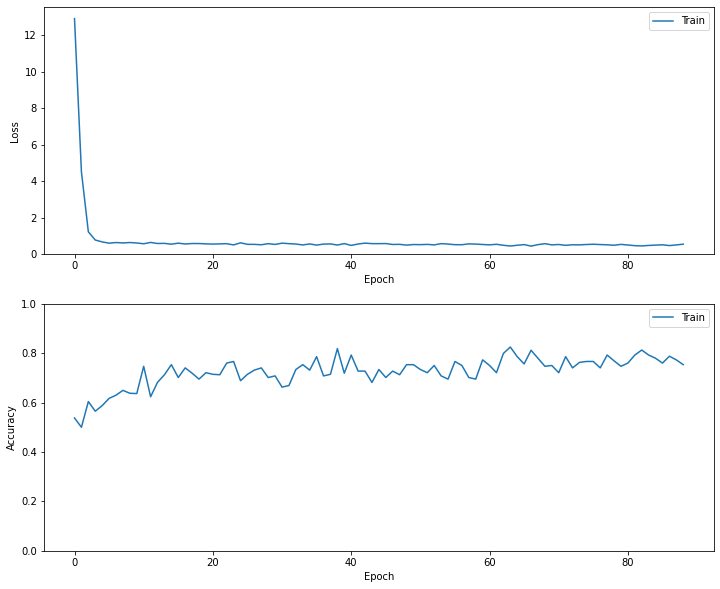

In [ ]:
plot_metrics(baseline_history)

## Evaluate Metrics

In [ ]:
train_predictions_baseline = model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(x_test, batch_size=BATCH_SIZE)

In [ ]:
y_pred = np.zeros(51)
for i in range(51):
  if test_predictions_baseline[i]>0.5:
    y_pred[i] = 1
  else :
    y_pred[i] = 0

In [ ]:
count = 0
for i in range(51):
  if y_pred[i]==y_test[i]:
    count+=1

acc = count/51
acc

0.8235294117647058

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
baseline_results = model.evaluate(x_train,y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


loss :  0.4640135169029236
accuracy :  0.7920792102813721



Legitimate Transactions Detected (True Negatives):  15
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  4
Fraudulent Transactions Detected (True Positives):  27
Total Fraudulent Transactions:  31


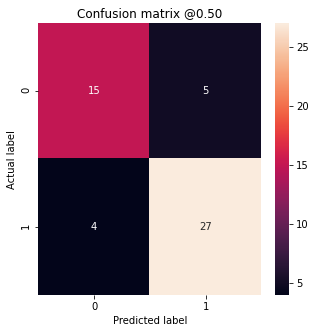

In [ ]:
plot_cm(y_test, test_predictions_baseline)

### plot the ROC

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp,label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

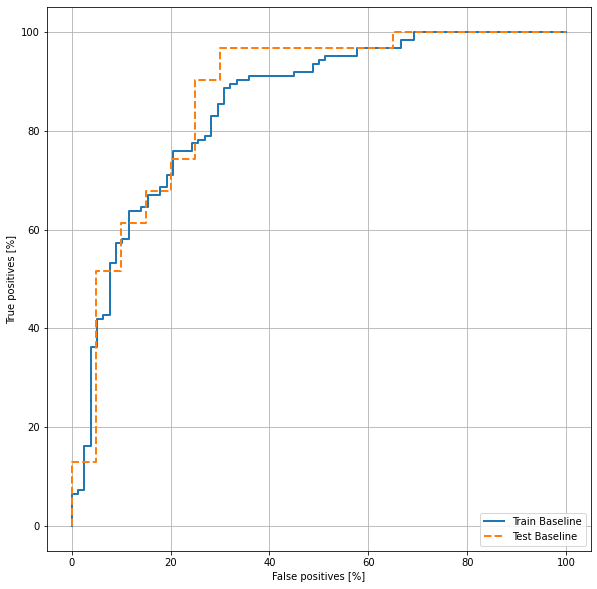

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

### plot the AURPC

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, linewidth=2, **kwargs)#, label=name
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

No handles with labels found to put in legend.


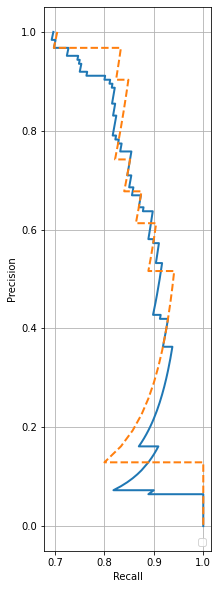

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

dropout add korar pore acc komse

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = pos+neg
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.29
Weight for class 1: 0.82


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stopping],
    #validation_data=(x_val,y_val),
    # The class weights go here
    class_weight=class_weight) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


13/13 [==============================] - 1s 28ms/step - loss: 12.5756 - accuracy: 0.5803
Epoch 2/100
13/13 [==============================] - 0s 26ms/step - loss: 2.1869 - accuracy: 0.7322
Epoch 3/100
13/13 [==============================] - 0s 26ms/step - loss: 0.6143 - accuracy: 0.7819
Epoch 4/100
13/13 [==============================] - 0s 26ms/step - loss: 0.3916 - accuracy: 0.7974
Epoch 5/100
13/13 [==============================] - 0s 26ms/step - loss: 0.2527 - accuracy: 0.9026
Epoch 6/100
13/13 [==============================] - 0s 26ms/step - loss: 0.1557 - accuracy: 0.9416
Epoch 7/100
13/13 [==============================] - 0s 25ms/step - loss: 0.1185 - accuracy: 0.9608
Epoch 8/100
13/13 [==============================] - 0s 27ms/step - loss: 0.0990 - accuracy: 1.0000
Epoch 9/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0697 - accuracy: 0.9782
Epoch 10/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0605 - accuracy: 0.9951
Epoch 11/1

### Check training history

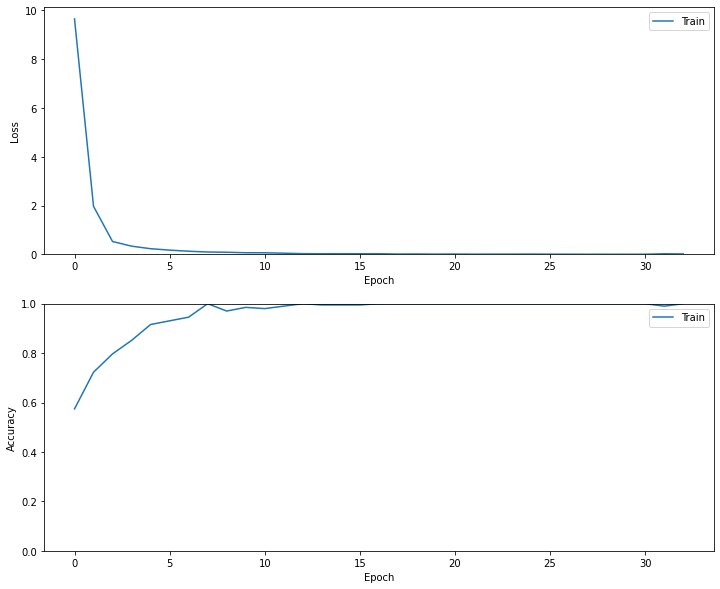

In [ ]:
plot_metrics(weighted_history)

### Evaluate metrics

In [ ]:
train_predictions_weighted = weighted_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


loss :  0.3144627511501312
accuracy :  0.8823529481887817

Legitimate Transactions Detected (True Negatives):  16
Legitimate Transactions Incorrectly Detected (False Positives):  4
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  29
Total Fraudulent Transactions:  31


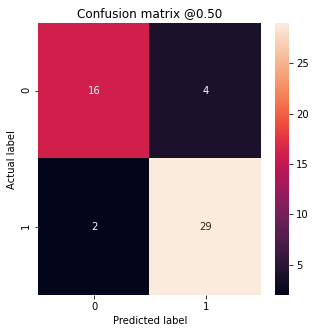

In [ ]:
weighted_results = weighted_model.evaluate(x_test,y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

### plot the ROC

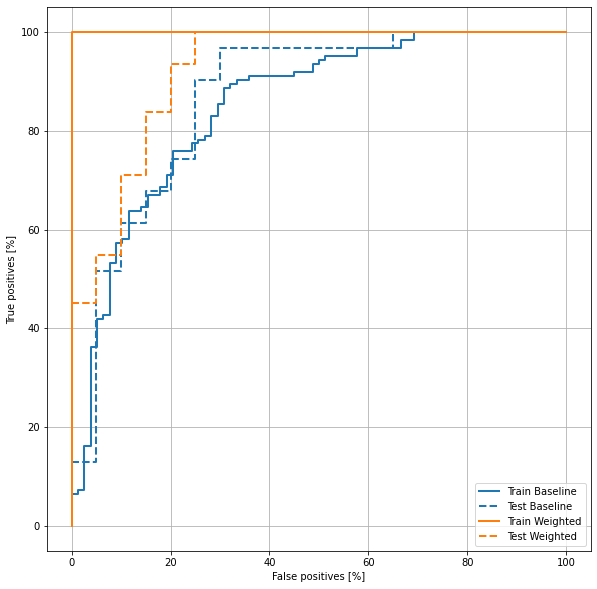

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

### Plot the AUPRC

No handles with labels found to put in legend.


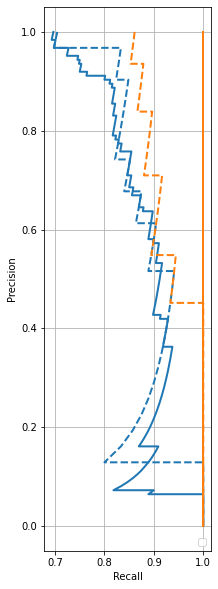

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [ ]:
bool_train_labels = y_train != 0
bool_train_labels.shape

(202,)

In [ ]:
pos_features = x_train[bool_train_labels]
neg_features = x_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(78, 224, 224, 3)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(156, 224, 224, 3)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:


In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

Label:  1


Merge the two together using `experimental.sample_from_datasets`:

In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5625


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

13.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

#val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).cache()
#val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=INITIAL_EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping])#,
    #validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


13/13 [==============================] - 1s 30ms/step - loss: 7.6856 - accuracy: 0.5677
Epoch 2/100
13/13 [==============================] - 0s 28ms/step - loss: 2.2998 - accuracy: 0.6490
Epoch 3/100
13/13 [==============================] - 0s 29ms/step - loss: 0.5135 - accuracy: 0.7624
Epoch 4/100
13/13 [==============================] - 0s 30ms/step - loss: 0.3429 - accuracy: 0.8832
Epoch 5/100
13/13 [==============================] - 0s 27ms/step - loss: 0.2310 - accuracy: 0.9211
Epoch 6/100
13/13 [==============================] - 0s 28ms/step - loss: 0.1911 - accuracy: 0.9066
Epoch 7/100
13/13 [==============================] - 0s 28ms/step - loss: 0.1486 - accuracy: 0.9861
Epoch 8/100
13/13 [==============================] - 0s 28ms/step - loss: 0.1287 - accuracy: 0.9799
Epoch 9/100
13/13 [==============================] - 0s 28ms/step - loss: 0.0711 - accuracy: 0.9733
Epoch 10/100
13/13 [==============================] - 0s 28ms/step - loss: 0.0473 - accuracy: 0.9926
Epoch 11/10

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

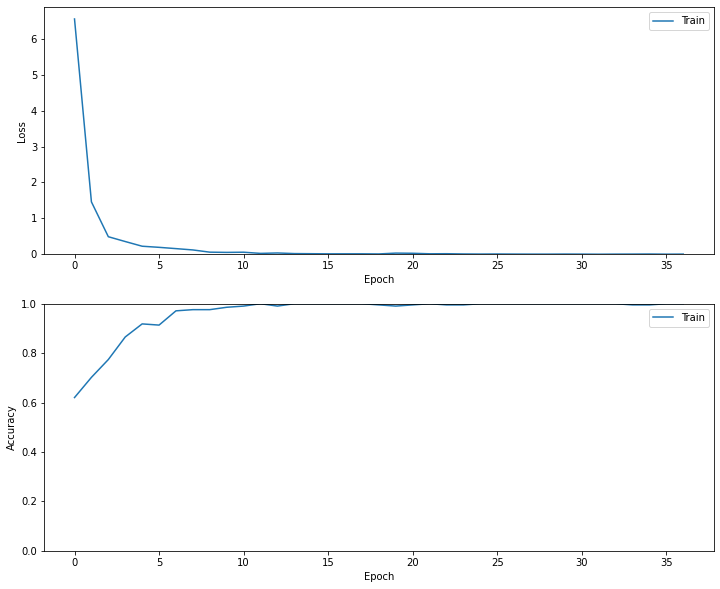

In [ ]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stopping])#,
    #validation_data=(val_ds))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


20/20 [==============================] - 2s 28ms/step - loss: 5.4954 - accuracy: 0.5951
Epoch 2/100
20/20 [==============================] - 1s 26ms/step - loss: 0.4728 - accuracy: 0.7974
Epoch 3/100
20/20 [==============================] - 1s 27ms/step - loss: 0.2785 - accuracy: 0.8896
Epoch 4/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1678 - accuracy: 0.9515
Epoch 5/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1164 - accuracy: 0.9536
Epoch 6/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0802 - accuracy: 0.9681
Epoch 7/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0219 - accuracy: 0.9997
Epoch 8/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0222 - accuracy: 0.9950
Epoch 9/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 10/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0113 - accuracy: 0.9972
Epoch 11/10

### Re-check training history

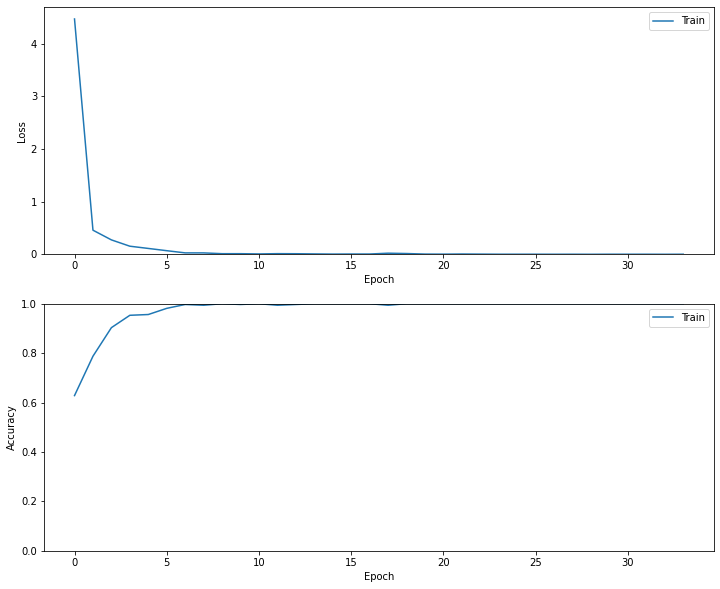

In [ ]:
plot_metrics(resampled_history)

### Evaluate metrics

In [ ]:
train_predictions_resampled = resampled_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(x_test, batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


loss :  0.3439476490020752
accuracy :  0.9019607901573181

Legitimate Transactions Detected (True Negatives):  16
Legitimate Transactions Incorrectly Detected (False Positives):  4
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  30
Total Fraudulent Transactions:  31


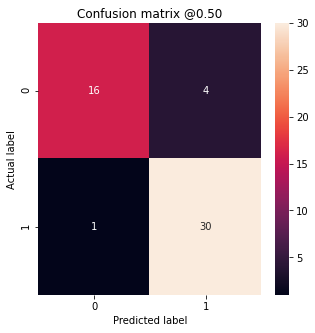

In [ ]:
resampled_results = resampled_model.evaluate(x_test,y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

### Plot the ROC

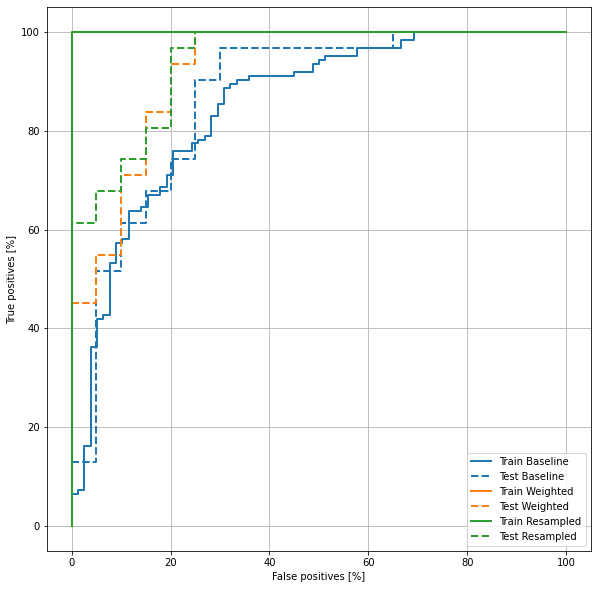

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### Plot the AUPRC


No handles with labels found to put in legend.


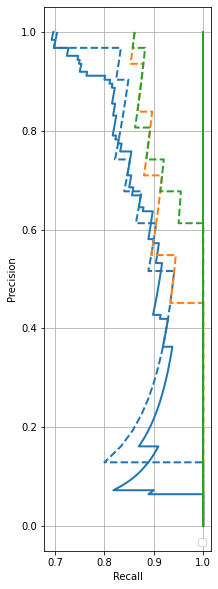

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

# 3. Transfer Learning (VGG16)

other models will be mentioned in report and presentation but this works best

80_20_split train_test

## imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2


from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data Preprocessing

80_20 train_test_split

batch size 16 gives best result

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (224,224)

train_dir = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/'
test_dir  = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/'

### Dataset_creation

In [ ]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 202 files belonging to 2 classes.


In [ ]:
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 51 files belonging to 2 classes.


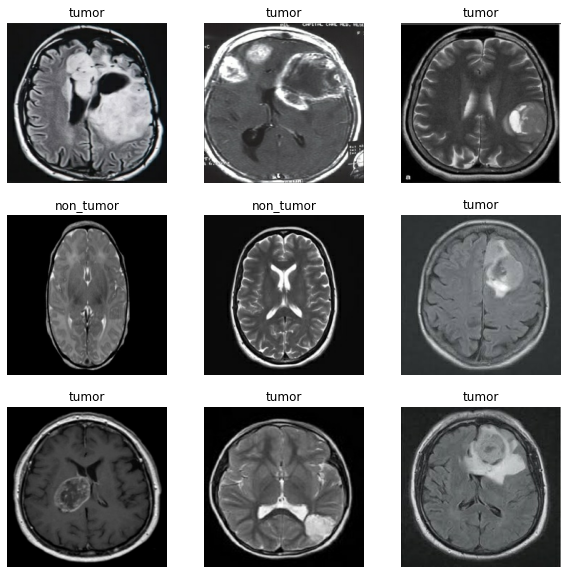

In [ ]:
#Show the first nine images and labels from the training set:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configuring the dataset performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

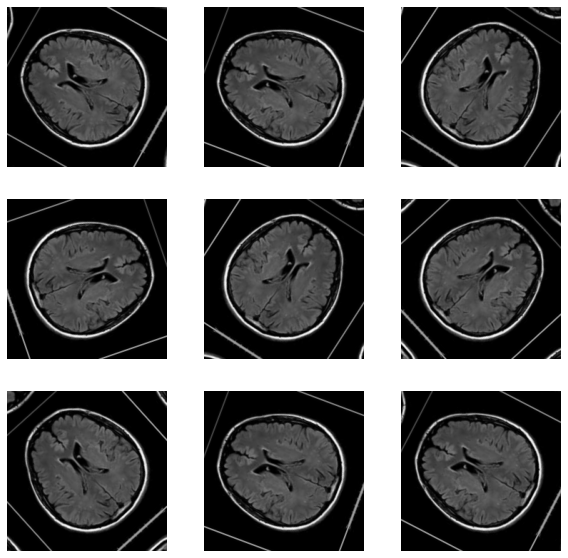

In [ ]:
#repeatedly applying augmentation to the same image
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### rescale pixel values

In [ ]:
preprocess_input =  tf.keras.applications.vgg16.preprocess_input

## Create the base model from the pre-trained convnets

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16 as tl_model

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tl_model(weights= 'imagenet', input_tensor= Input(shape = IMG_SHAPE), include_top= False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


## Feature extraction

### Freeze the convolutional base

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Add a classification head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [ ]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [ ]:
len(model.trainable_variables)

2

### Train the model

In [ ]:
initial_epochs = 250

loss0, accuracy0 = model.evaluate(train_dataset)

13/13 [==============================] - 7s 262ms/step - loss: 1.3180 - accuracy: 0.5941


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.32
initial accuracy: 0.59


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=25,
    mode='max',
    restore_best_weights=True)

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=[early_stopping])

Epoch 1/250
13/13 [==============================] - 2s 69ms/step - loss: 1.7257 - accuracy: 0.5792
Epoch 2/250
13/13 [==============================] - 1s 68ms/step - loss: 1.5866 - accuracy: 0.5594
Epoch 3/250
13/13 [==============================] - 1s 68ms/step - loss: 1.3707 - accuracy: 0.5842
Epoch 4/250
13/13 [==============================] - 1s 69ms/step - loss: 1.6536 - accuracy: 0.6139
Epoch 5/250
13/13 [==============================] - 1s 68ms/step - loss: 1.6894 - accuracy: 0.5941
Epoch 6/250
13/13 [==============================] - 1s 68ms/step - loss: 1.4652 - accuracy: 0.5743
Epoch 7/250
13/13 [==============================] - 1s 69ms/step - loss: 1.3665 - accuracy: 0.6386
Epoch 8/250
13/13 [==============================] - 1s 68ms/step - loss: 1.3342 - accuracy: 0.6634
Epoch 9/250
13/13 [==============================] - 1s 69ms/step - loss: 1.2381 - accuracy: 0.6089
Epoch 10/250
13/13 [==============================] - 1s 68ms/step - loss: 1.2413 - accuracy: 0.6040

### Learning Curves

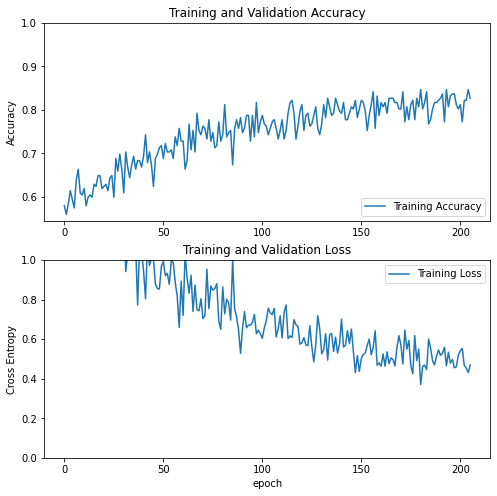

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

## Fine-tune from this layer onwards
#fine_tune_at = 100

## Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#  layer.trainable =  False

Number of layers in the base model:  19


### compiling the model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [ ]:
len(model.trainable_variables)

28

### continue training the model

In [ ]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=[early_stopping])

Epoch 206/350
13/13 [==============================] - 9s 366ms/step - loss: 0.7025 - accuracy: 0.8020
Epoch 207/350
13/13 [==============================] - 3s 213ms/step - loss: 0.4089 - accuracy: 0.8218
Epoch 208/350
13/13 [==============================] - 3s 213ms/step - loss: 0.2888 - accuracy: 0.9158
Epoch 209/350
13/13 [==============================] - 3s 213ms/step - loss: 0.2952 - accuracy: 0.8762
Epoch 210/350
13/13 [==============================] - 3s 212ms/step - loss: 0.2604 - accuracy: 0.8911
Epoch 211/350
13/13 [==============================] - 3s 213ms/step - loss: 0.1889 - accuracy: 0.9109
Epoch 212/350
13/13 [==============================] - 3s 212ms/step - loss: 0.1381 - accuracy: 0.9505
Epoch 213/350
13/13 [==============================] - 3s 213ms/step - loss: 0.2808 - accuracy: 0.9010
Epoch 214/350
13/13 [==============================] - 3s 213ms/step - loss: 0.1275 - accuracy: 0.9455
Epoch 215/350
13/13 [==============================] - 3s 212ms/step - lo

In [ ]:
acc += history_fine.history['accuracy']

loss += history_fine.history['loss']

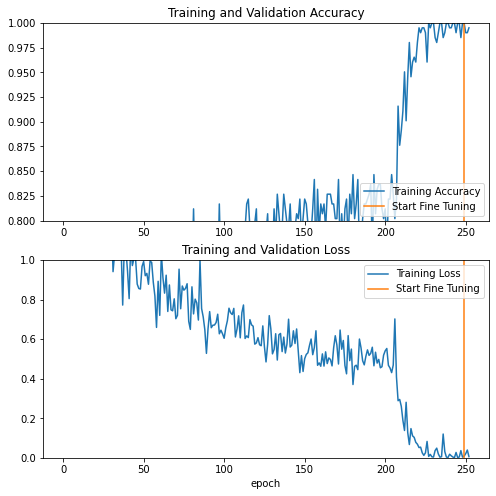

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 2s 446ms/step - loss: 0.2240 - accuracy: 0.9412
Test accuracy : 0.9411764740943909


Predictions:
 [1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0]
Labels:
 [1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0]


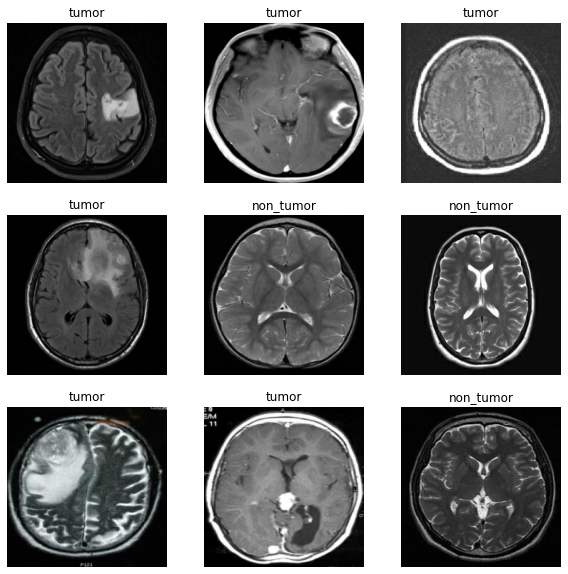

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")